In [32]:
import numpy as np
import json
from matplotlib import pyplot as plt
import os
import Hamiltonians.helper as helper
import Hamiltonians.hamiltonians as ham
from sklearn.cluster import DBSCAN

plt.rcParams['figure.dpi'] = 150
system = "linear_4"
keys = ["run"+str(i) for i in range(1,2)]
colors = ["steelblue","g","gray"]
n_points = 0
for i in range(len(keys)):
    dir_path = keys[i] +"/results"
    n_points += len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))])
data = {"mix_energy": [], "mix_shots": [],"mix_moments":[], "qwc_energy": [], "qwc_shots":[],"qwc_moments":[], "cs_energy":[], "cs_shots":[],"cs_moments":[]}

In [3]:
data

{'mix_energy': [],
 'mix_shots': [],
 'mix_moments': [],
 'qwc_energy': [],
 'qwc_shots': [],
 'qwc_moments': [],
 'cs_energy': [],
 'cs_shots': [],
 'cs_moments': []}

<h1> Step 1) Collect and Organize Results </h1>

In [4]:
with open("saved_hamiltonians/linear_4_1.json") as fp:
    k = json.load(fp)
ham_qm = ham.Hamiltonian(list(k.keys()), [complex(s) for s in list(k.values())])

In [5]:
ham_mat = ham_qm.to_matrix()

In [6]:
n_points

120

In [7]:
for j in range(len(keys)):
    dir_path = keys[j] +"/results"
    nps = len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))])
    for i in range(nps):
        with open(dir_path+"/"+str(i)+".json") as fp:
            dat_ = json.load(fp)
            for key in data:
                data[key] += [dat_[key]]

In [8]:
for key in data:
    data[key] = np.array(data[key]).T

**Remove Outliers Using DBSCAN Protocol ($\epsilon = 5$, $minsamples = 5$)**

In [9]:
data["mix_energy"].shape

(5, 120)

In [10]:
ks = [1,2,3,4,5]
data_no_outliers = {"mix_energy": [], "mix_shots": [],"mix_moments":[], "qwc_energy": [], "qwc_shots":[],"qwc_moments":[], "cs_energy":[], "cs_shots":[],"cs_moments":[]}
data_no_outliers_save = {"mix_energy": [], "mix_shots": [],"mix_moments":[], "qwc_energy": [], "qwc_shots":[],"qwc_moments":[], "cs_energy":[], "cs_shots":[],"cs_moments":[]}
for key in ["mix_energy", "cs_energy","qwc_energy"]:
    data_no_outliers[key] = [0]*len(ks)
    data_no_outliers_save[key] = [0]*len(ks)
    for i in range(len(ks)):
        X = np.array(data[key][i]).reshape(-1,1)
        clustering = DBSCAN(eps=5, min_samples=5).fit(X)
        clustering.labels_
        Y = np.array([np.inf]*len(X))
        indeces = np.where(clustering.labels_ != -1)[0]
        Y[indeces] = X[indeces].reshape(1,-1)[0]

        data_no_outliers[key][i] = X[indeces].reshape(1,-1)[0]
        data_no_outliers_save[key][i] = Y

In [11]:
import pandas as pd

row_names = {"system":[], "method":[], "shots":[], "computer":[]}
for i in range(ks[-1]*2):
    row_names["Moment " + str(i)] = []
for k in ks:
    row_names["PDS " + str(k)] = []
df = pd.DataFrame(row_names)
print(df)
from tqdm import tqdm
for key_ in ["mix", "qwc", "cs"]:
    for i in tqdm(range(n_points)):
        row = [system, key_,data[key_+"_shots"][i],"qasm simulator"]
        for j in range(ks[-1]*2):
            row += [complex(data[key_+"_moments"][j][i]).real]
        for k in range(len(ks)):
            row += [complex(data[key_+"_energy"][k][i]).real]
        df.loc[len(df.index)] = row
print(df)
df.to_csv('results.csv', index=False)


Empty DataFrame
Columns: [system, method, shots, computer, Moment 0, Moment 1, Moment 2, Moment 3, Moment 4, Moment 5, Moment 6, Moment 7, Moment 8, Moment 9, PDS 1, PDS 2, PDS 3, PDS 4, PDS 5]
Index: []


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 254.12it/s]


       system method  shots        computer  Moment 0  Moment 1  Moment 2  \
0    linear_4    mix  21501  qasm simulator       1.0  1.951168  6.783439   
1    linear_4    mix  21501  qasm simulator       1.0  1.795471  7.043878   
2    linear_4    mix  21501  qasm simulator       1.0  1.897381  7.080679   
3    linear_4    mix  21501  qasm simulator       1.0  1.843595  7.106157   
4    linear_4    mix  21501  qasm simulator       1.0  1.884643  6.690021   
..        ...    ...    ...             ...       ...       ...       ...   
355  linear_4     cs  21465  qasm simulator       1.0  1.754358  7.593345   
356  linear_4     cs  21465  qasm simulator       1.0  1.804279  7.339848   
357  linear_4     cs  21465  qasm simulator       1.0  1.918322  7.088871   
358  linear_4     cs  21465  qasm simulator       1.0  1.868463  6.103980   
359  linear_4     cs  21465  qasm simulator       1.0  1.861331  7.459588   

      Moment 3    Moment 4    Moment 5     Moment 6      Moment 7  \
0    1

In [12]:
import pandas as pd
from tqdm import tqdm
row_names = {"system":[], "method":[], "shots":[], "computer":[]}
for k in ks:
    row_names["PDS " + str(k)] = []
df = pd.DataFrame(row_names)

for key_ in ["mix", "qwc", "cs"]:
    for i in tqdm(range(n_points)):
        row = [system, key_,data[key_+"_shots"][i],"qasm simulator"]
        
        for k in range(len(ks)):
            if(data_no_outliers_save[key_+"_energy"][k][i] == np.inf):
                row += ["X"]
            else:
                row += [data_no_outliers_save[key_+"_energy"][k][i]]
        df.loc[len(df.index)] = row
print(df)
df.to_csv('results_no_outliers.csv', index=False)


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 258.09it/s]

       system method  shots        computer     PDS 1     PDS 2     PDS 3  \
0    linear_4    mix  21501  qasm simulator  1.951168 -2.701269 -5.323848   
1    linear_4    mix  21501  qasm simulator  1.795471 -3.254105 -5.378461   
2    linear_4    mix  21501  qasm simulator  1.897381 -3.633581 -5.819954   
3    linear_4    mix  21501  qasm simulator  1.843595 -3.531177 -5.800756   
4    linear_4    mix  21501  qasm simulator  1.884643 -2.750273 -5.009582   
..        ...    ...    ...             ...       ...       ...       ...   
355  linear_4     cs  21465  qasm simulator  1.754358 -4.060052  -5.72712   
356  linear_4     cs  21465  qasm simulator  1.804279 -3.898744 -5.756267   
357  linear_4     cs  21465  qasm simulator  1.918322 -3.285633 -5.101324   
358  linear_4     cs  21465  qasm simulator  1.868463 -1.039446         X   
359  linear_4     cs  21465  qasm simulator  1.861331 -4.492854 -6.568954   

        PDS 4     PDS 5  
0   -6.244141 -6.456601  
1   -6.292291 -6.458681

In [13]:
data_no_outliers_save

{'mix_energy': [array([1.95116773, 1.79547063, 1.89738146, 1.84359519, 1.8846426 ,
         1.85067233, 1.85491861, 1.82519462, 1.85491861, 1.80962491,
         1.85491861, 1.89030432, 1.95258316, 1.70629866, 1.69780609,
         1.84642604, 1.81528662, 1.77565464, 1.79547063, 1.76150035,
         1.9398443 , 1.7841472 , 1.74309979, 1.75300778, 1.89171975,
         1.76291578, 1.79830149, 1.81670205, 1.77140835, 1.79688606,
         1.84784147, 1.88322718, 1.74026893, 1.7841472 , 1.77848549,
         1.78839349, 1.81528662, 1.8945506 , 1.80537863, 1.92427459,
         1.8039632 , 1.81670205, 1.82661005, 1.85208776, 1.85350318,
         1.8945506 , 1.88605803, 1.87048832, 1.74734607, 1.87473461,
         1.88888889, 1.91153574, 1.84076433, 1.82802548, 1.82377919,
         1.82944091, 1.86199575, 1.75017693, 1.80962491, 1.89313517,
         1.86765747, 1.91153574, 1.89030432, 1.72611465, 1.78131635,
         1.87756546, 1.75725407, 1.84642604, 1.83227176, 1.83368719,
         1.76999292,

<h1> Step 2) Visualize Data </h1>

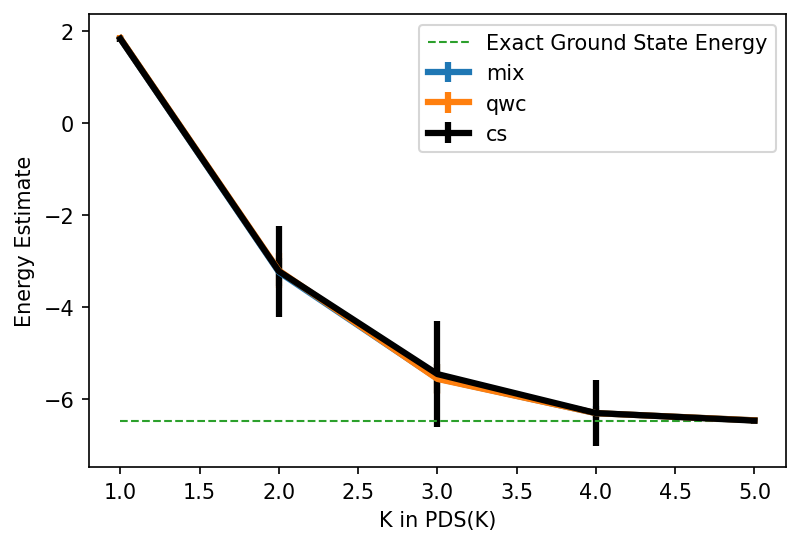

In [14]:
plt.errorbar(ks, [np.mean(data_no_outliers["mix_energy"][i]) for i in range(len(ks))], 
             yerr=[np.std(data_no_outliers["mix_energy"][i]) for i in range(len(ks))], lw =3, label="mix")
plt.errorbar(ks, [np.mean(data_no_outliers["qwc_energy"][i]) for i in range(len(ks))], 
             yerr=[np.std(data_no_outliers["qwc_energy"][i]) for i in range(len(ks))], lw =3, label="qwc")
plt.errorbar(ks, [np.mean(data_no_outliers["cs_energy"][i]) for i in range(len(ks))], 
             yerr=[np.std(data_no_outliers["cs_energy"][i]) for i in range(len(ks))], lw = 3, color="black", label="cs")
min_e = np.min(np.linalg.eigh(ham_mat)[0])
plt.plot(ks,[min_e]*len(ks),lw = 1, linestyle="dashed", label="Exact Ground State Energy")
plt.legend()
plt.xlabel("K in PDS(K)")
plt.ylabel("Energy Estimate")
plt.savefig("figures/energy_"+system+".jpg")

Looks pretty good! A prettier version of the plot will follow.

(21511.8, 0)


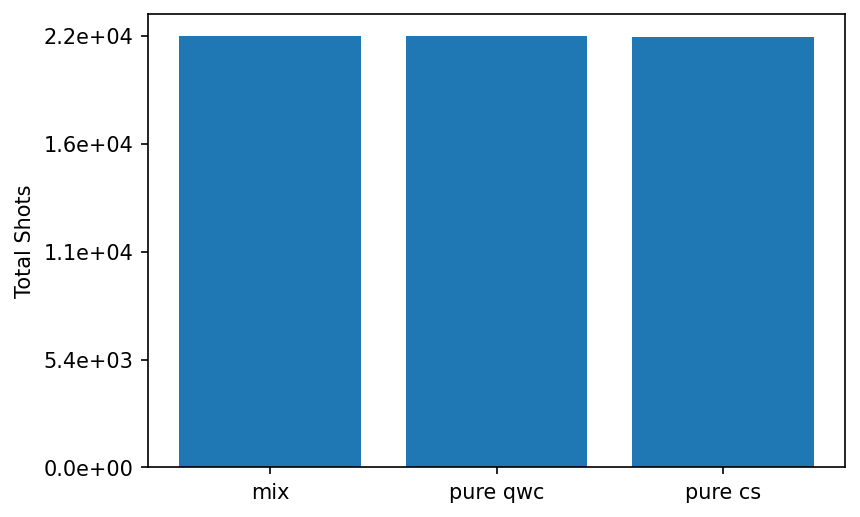

In [15]:
plt.bar(["mix","pure qwc","pure cs"],[data["mix_shots"].mean(), data["qwc_shots"].mean(), data["cs_shots"].mean()])
def get_ticks_shots(data_, p=35, n_ticks=5):
    # helper function to scale y-axis nicely
    max_ = -1000
    d1 = [np.mean(data_["mix_shots"][i]) for i in range(len(ks))] 
    d2 = [np.mean(data_["qwc_shots"][i]) for i in range(len(ks))]
    d3 = [np.mean(data_["cs_shots"][i]) for i in range(len(ks))] 
    max_ = max(max(d1), max(d2), max(d3))
    min_ = min(min(d1), min(d2), min(d3))
    bounds = (max_ + (0.01 * p) * (max_-min_), 0)
    print(bounds)
    ticks = np.linspace(bounds[0], bounds[1], n_ticks+2)
    return ticks
import matplotlib.ticker as mtick
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))

sticks = get_ticks_shots(data,20,3)
plt.yticks(sticks)
plt.ylabel("Total Shots")
plt.savefig("figures/shots_"+system+".jpg")

**Set up analytical version of the system to calculate exact PDS(K) for comparison to moment mixing scheme**

In [16]:
n_qubits = 4
K = 5
ket0 = np.array([1.,0.],dtype=complex)
ket1 = np.array([0.,1.],dtype=complex)


PauliX = np.array([[0.,1.],[1.,0]], dtype=complex)
PauliY = np.array([[0.,-1.j],[1.j,0]], dtype=complex)
PauliZ = np.array([[1.0,0.],[0.,-1.]], dtype=complex)
PauliI = np.eye(2, dtype=complex)
PauliVec = [PauliX, PauliY, PauliZ]
cz = np.eye(4)
cz[3,3] = -1
PauliDict = {"Identity": "I", "PauliX": "X", "PauliY": "Y", "PauliZ": "Z"}
PauliNumToLetter = {0: "X", 1: "Y", 2: "Z"}
PauliDict_2 = {"I": PauliI, "X": PauliX, "Y": PauliY, "Z": PauliZ}
Hadamard = (1/np.sqrt(2)) * np.array([[1,1],[1,-1]])
CNOT = np.eye(4)
CNOT[3,3]=0
CNOT[2,2] = 0 
CNOT[3,2] = 1
CNOT[2,3] = 1
thetaTest = [-2,1]
cz = np.eye(4)
cz[3,3] = -1


"""

====================
FUNCTION DEFINITIONS
++++++++++++++++++++


"""

def RY(theta):
    '''
        matrix representation of the RY gate in the Z computational basis
    '''
    matrix = np.zeros((2,2),dtype=complex)
    matrix[0,0] = np.cos(theta/2)
    matrix[1,1] = np.cos(theta/2)
    matrix[0,1] = -np.sin(theta/2)
    matrix[1,0] =  np.sin(theta/2)
    return matrix
def RZ(theta):
    matrix = np.zeros((2,2), dtype=complex)
    matrix[0,0] = np.exp(-1.j * theta/2)
    matrix[1,1] = np.exp(1.j * theta/2)
    return matrix
def linear_hamiltonian_matrix_dict(j,u,b=1.0,n=10):
    '''
        represent our Hamiltonian as a matrix
    '''
    combos = list(combinations([int(i) for i in range(n)],2))
    H = {}
    for i in range(n-1):
        next_ = i+1

        for k in range(3):
            A = ["I" for i in range(n)]
            A[i] = PauliNumToLetter[k]
            A[next_] = PauliNumToLetter[k]
            x = j
            if(k==2):
                x = u
            H["".join(A)] = x
    return H

def linear_hamiltonian_matrix(j,u,b=1.0,n=10):
    '''
        represent our Hamiltonian as a matrix
    '''
    combos = list(combinations([int(i) for i in range(n)],2))
    H = np.zeros((2**n, 2**n), dtype=complex)
    for i in range(n-1):
        next_ = i+1

        for k in range(3):
            A = [PauliI for i in range(n)]
            A[i] = PauliVec[k]
            A[next_] = PauliVec[k]
            x = j
            if(k==2):
                x = u
            add = [1]
            for qbit in range(n):
                
                add = np.kron(add, A[qbit])
            H += x*add
    return H

def circuit(theta):
    qc = qm.QuantumCircuit(n_qubits,n_qubits)
    for w in range(n_qubits-1):
        qc.h(w)
        qc.ry(theta[w], w)
    for w in range(n_qubits-1):
        qc.cnot(w, w+1)
    for w in range(n_qubits):
        qc.rz(theta[w + n_qubits], w)
    return qc

def circuit_numerical(theta):
    psi = np.zeros(2 ** n_qubits)
    print(2**n_qubits)
    psi[0] = 1 # initialize in |0000....000>
    for w in range(n_qubits-1):
        obs_ = [1]
        for i in range(n_qubits):
            if not i == w:
                obs_ = np.kron(obs_, PauliI)
            else:
                obs_ = np.kron(obs_, Hadamard)
        psi = obs_ @ psi 
        obs_ = [1]
        for i in range(n_qubits):
            if not i == w:
                obs_ = np.kron(obs_, PauliI)
            else:
                obs_ = np.kron(obs_, RY(theta[w]))
        psi = obs_ @ psi 
    for w in range(n_qubits-1):
        obs_ = [1]
        for i in range(n_qubits):
            if not i == w and not i == w+1:
                obs_ = np.kron(obs_, PauliI)
            elif i == w:
                obs_ = np.kron(obs_, CNOT)
            elif i == w+1:
                pass;
            
        psi = obs_ @ psi
    for w in range(n_qubits):
        obs_ = [1]
        for i in range(n_qubits):
            if not i == w:
                obs_ = np.kron(obs_, PauliI)
            else:
                obs_ = np.kron(obs_, RZ(theta[w+n_qubits]))
        psi = obs_ @ psi
    return psi



def tildeM(e_dict, K):
    M = np.zeros((K,K), dtype=complex)
    for i in range(1,K+1):
        for j in range(1,K+1):
            M[i-1,j-1] = e_dict[int(2*K-i-j)]
    return M

def tildeY(e_dict, K):
    Y = np.zeros(K, dtype=complex)
    for i in range(1,K+1):
        Y[i-1] = e_dict[int(2*K-i)]
    return Y
def comp_energy(moments, K):
    M_ = tildeM(moments, K)
    Y_ = tildeY(moments, K)
    X_ = np.linalg.lstsq(M_, -Y_,rcond=None)[0]
    coeffs = np.ones(K+1)
    for k in range(1,K+1):
        coeffs[k] = X_[k-1].real
    return np.min(np.roots(coeffs)).real

In [17]:
theta_test = np.genfromtxt(keys[0]+"/theta_4_save.txt") # load the rotation used to prepare the ansatz
                                                        # all rotations for each run is are the same
                                                        # here we use the first run, however it shouldn't matter
psi_numerical = circuit_numerical(theta_test)

16


In [18]:
exps = {}
for i in range(2*K):
    with open("saved_hamiltonians/linear_4_"+str(i)+".json") as fp:
        k = json.load(fp)
        for key in k:
            if key not in exps:
                exps[key] = np.conjugate(psi_numerical).T @ ham.Hamiltonian([key],[1]).to_matrix() @ psi_numerical

In [19]:
exps

{'IIII': (0.9999999999999992+0j),
 'XXII': (-0.3732131224640195+0j),
 'YYII': (0.40701459777897087+0j),
 'ZZII': (0.8554624934993634+0j),
 'IXXI': 0j,
 'IYYI': 0j,
 'IZZI': (-0.054724575342061293+0j),
 'IIXX': (-0.5634245512236737+0j),
 'IIYY': (0.5634245512236737+0j),
 'IIZZ': (0.9999999999999992+0j),
 'XIXI': 0j,
 'XXXX': (0.22057254894344375+1.3877787807814457e-17j),
 'XXYY': (-0.22057254894344375-1.3877787807814457e-17j),
 'XXZZ': (-0.3732131224640195+0j),
 'YIYI': 0j,
 'YYXX': (-0.23704458001345402+0j),
 'YYYY': (0.23704458001345402+0j),
 'YYZZ': (0.40701459777897087+0j),
 'ZIZI': (-0.04681482167781359+0j),
 'ZZXX': (-0.4819885714885641+0j),
 'ZZYY': (0.4819885714885641+0j),
 'ZZZZ': (0.8554624934993634+0j),
 'IXIX': 0j,
 'IYIY': 0j,
 'IZIZ': (-0.054724575342061293+0j),
 'XIIX': 0j,
 'XZZX': 0j,
 'XYYX': (0.18812595335855475-3.469446951953614e-18j),
 'XYXY': (0.18812595335855475-3.469446951953614e-18j),
 'XZXZ': 0j,
 'YIIY': 0j,
 'YXYX': (0.14111690899531865+6.938893903907228e-18j

In [20]:

def lettersToNums(l):
    # some simple helper func to convert the pauli strings
    # into the form that the shadows use
    numsL = []
    for i in l:
        if(i == "X"):
            numsL += [0]
        elif(i == "Y"):
            numsL += [1]
        elif(i == "Z"):
            numsL += [2]
        else:
            numsL += [3]
    return numsL


In [21]:
def estimate_shadow_observable_fast(shadow, target_obs, k=10):
    '''Estimate the expectation value of an observabley,
    with k median of means chunks'''
    means = []
    snap, obs = shadow
    chunk_size = len(snap) // k
    pauli_locations = [i for i in range(len(target_obs)) if target_obs[i] != 3]
    tobs = target_obs[pauli_locations]
    snap2 = snap[:,pauli_locations]
    obs2 = obs[:,pauli_locations]
    nper = int(np.floor(len(obs) / k))
    num_per_max = [nper] * k
    num_per_max[-1] = len(snap) - nper * (k - 1)
    for i in range(k):
        snap_chunk, obs_chunk = (
            snap2[i * nper : i *nper + num_per_max[i]],
            obs2[i * nper : i *nper + num_per_max[i]],
        )
        indices = np.all(obs_chunk == tobs, axis=1)
        if sum(indices) > 0:
            means += [np.sum(np.prod(snap_chunk[indices], axis=1))/sum(indices)]
        else:
            means += [0]
    return np.median(means)

In [22]:
moments = {i: np.conjugate(psi_numerical).T @ np.linalg.matrix_power(ham_qm.to_matrix(), i) @ psi_numerical for i in range(0,15)}

In [23]:
print("Exact Moments:")
print(moments)

Exact Moments:
{0: (0.9999999999999992+0j), 1: (1.834539393472253+1.1102230246251565e-16j), 2: (6.906370356644367-4.440892098500626e-16j), 3: (10.198326596526407+0j), 4: (82.96376489988322+0j), 5: (-60.75419303790294+0j), 6: (1659.2518551397443-1.4210854715202004e-14j), 7: (-6403.974326895098+0j), 8: (52199.70294360146-2.7284841053187847e-12j), 9: (-297038.7342452046+0j), 10: (2010171.9956264729+5.820766091346741e-11j), 11: (-12605743.085313888+2.3283064365386963e-10j), 12: (82196009.85637514-1.862645149230957e-09j), 13: (-527457140.50259906+0j), 14: (3414495976.7540355+0j)}


In [24]:
def moment(n, e_dict_, ham_):
    e = 0
    for i in range(len(ham_.letters)):
        e += ham_.coeffs[i] * e_dict_[ham_.letters[i]]
    return e

In [25]:
ks = [i for i in range(1, K+1)]
es = []
for k in ks:
    es += [comp_energy(moments, k)]

In [26]:
exact_pds = es
print(exact_pds)

[1.8345393934722545, -3.2315224148889676, -5.572883896037126, -6.320518095875549, -6.459961996640277]


**Calculate errors for moment mix runs**

In [27]:
errors = {}
errors["mix_energy"] = [0]*len(ks)
errors["cs_energy"] = [0]*len(ks)
errors["qwc_energy"] = [0]*len(ks)
for j in range(len(ks)):
    errors["mix_energy"][j] = np.abs(np.array(data_no_outliers["mix_energy"][j])-exact_pds[j])
    errors["cs_energy"][j] = np.abs(np.array(data_no_outliers["cs_energy"][j])-exact_pds[j])
    errors["qwc_energy"][j] = np.abs(np.array(data_no_outliers["qwc_energy"][j])-exact_pds[j])


In [28]:
def get_ticks(data_, p=35, n_ticks=5):
    max_ = -1000
    d1 = [np.mean(data_["mix_energy"][i]) for i in range(len(ks))] 
    d2 = [np.mean(data_["qwc_energy"][i]) for i in range(len(ks))]
    d3 = [np.mean(data_["cs_energy"][i]) for i in range(len(ks))] 
    max_ = max(max(d1), max(d2), max(d3))
    min_ = min(min(d1), min(d2), min(d3))
    bounds = (max_ + (0.01 * p) * (max_-min_), min_ - (0.01 * p) * (max_-min_))
    print(bounds)
    ticks = np.linspace(bounds[0], bounds[1], n_ticks+2)
    return ticks

In [29]:
ticks = get_ticks(data_no_outliers)
eticks = get_ticks(errors, 130)
print(eticks)

(4.7451022869610675, -9.372240703576022)
(1.735265880863591, -0.9764931235016893)
[ 1.73526588  1.28330605  0.83134621  0.37938638 -0.07257346 -0.52453329
 -0.97649312]


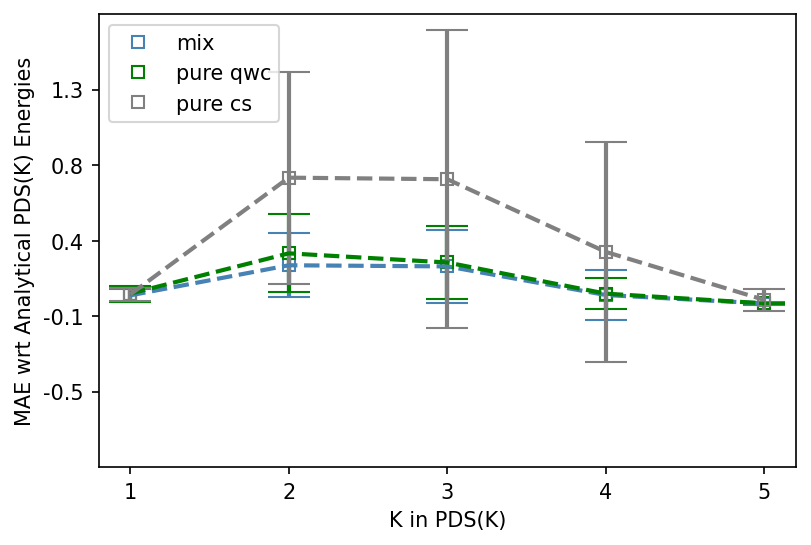

In [30]:
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import StrMethodFormatter
fig, ax1 = plt.subplots()
ax1.errorbar(ks, [np.mean(np.abs(errors["mix_energy"][i])) for i in range(len(ks))],
             yerr=[np.std(np.abs(errors["mix_energy"][i])) for i in range(len(ks))],
             capsize=10,lw =2,ls="dashed", color=colors[0])
ax1.plot(ks, [np.mean(np.abs(errors["mix_energy"][i])) for i in range(len(ks))],
          marker='s', color=colors[0],linestyle="none",fillstyle='none',label="mix")
ax1.errorbar(ks, [np.mean(np.abs(errors["qwc_energy"][i])) for i in range(len(ks))],
             yerr=[np.std(np.abs(errors["qwc_energy"][i])) for i in range(len(ks))],
             capsize=10,lw =2,ls="dashed", color=colors[1])
ax1.plot(ks, [np.mean(np.abs(errors["qwc_energy"][i])) for i in range(len(ks))],
          marker='s', color=colors[1],linestyle="none",fillstyle='none',label="pure qwc")
ax1.errorbar(ks, [np.mean(np.abs(errors["cs_energy"][i])) for i in range(len(ks))],
             yerr=[np.std(np.abs(errors["cs_energy"][i])) for i in range(len(ks))],
             capsize=10,lw =2,ls="dashed", color=colors[2])
ax1.plot(ks, [np.mean(np.abs(errors["cs_energy"][i])) for i in range(len(ks))],
          marker='s', color=colors[2],linestyle="none",fillstyle='none',label="pure cs")
ax1.set_xticks([1,2,3,4,5])
ax1.set_yticks(eticks[1:-1])
ax1.set_ylim((eticks[-1], eticks[0]))
ax1.legend(loc="upper left")
ax1.set_ylabel("MAE wrt Analytical PDS(K) Energies")
ax1.set_xlabel("K in PDS(K)")
ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) # 2 decimal places
plt.savefig("figures/mae_pretty_"+system+".jpg")

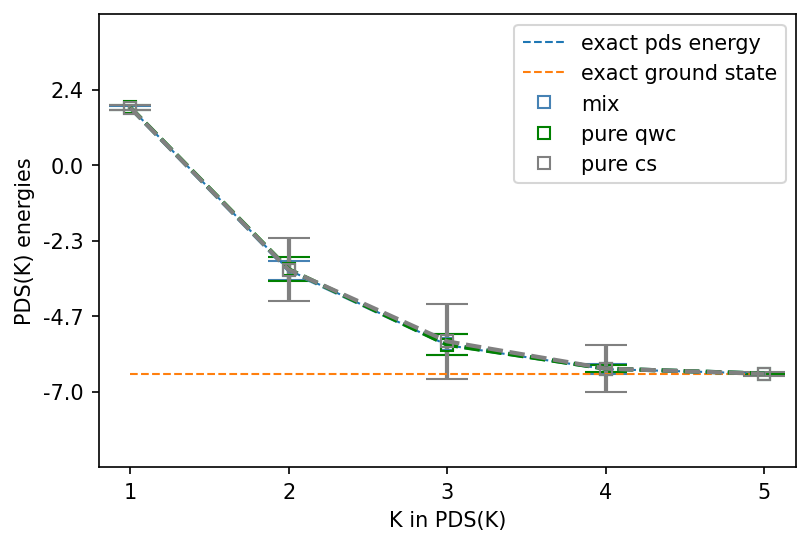

In [31]:
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import StrMethodFormatter

plt.errorbar(ks, [np.mean(data_no_outliers["mix_energy"][i]) for i in range(len(ks))], 
             yerr=[np.std(data_no_outliers["mix_energy"][i]) for i in range(len(ks))], lw =2, ls="dashed", capsize=10, color=colors[0])
plt.errorbar(ks, [np.mean(data_no_outliers["mix_energy"][i]) for i in range(len(ks))], marker="s", fillstyle="none",ls="none",label="mix", color=colors[0])
plt.errorbar(ks, [np.mean(data_no_outliers["qwc_energy"][i]) for i in range(len(ks))], 
             yerr=[np.std(data_no_outliers["qwc_energy"][i]) for i in range(len(ks))], lw =2, ls="dashed", capsize=10, color=colors[1])
plt.errorbar(ks, [np.mean(data_no_outliers["qwc_energy"][i]) for i in range(len(ks))], marker="s", fillstyle="none",ls="none",label="pure qwc", color=colors[1])
plt.errorbar(ks, [np.mean(data_no_outliers["cs_energy"][i]) for i in range(len(ks))], 
             yerr=[np.std(data_no_outliers["cs_energy"][i]) for i in range(len(ks))], lw =2, ls="dashed", capsize=10, color=colors[2])
plt.errorbar(ks, [np.mean(data_no_outliers["cs_energy"][i]) for i in range(len(ks))], marker="s", fillstyle="none",ls="none",label="pure cs", color=colors[2])
plt.plot(ks,exact_pds,lw = 1, linestyle="dashed", label="exact pds energy")
plt.plot(ks,[min_e]*len(ks),lw = 1, linestyle="dashed", label="exact ground state")
plt.legend()
plt.xticks([1,2,3,4,5])
plt.ylim((ticks[-1], ticks[0]))
plt.xlabel("K in PDS(K)")
plt.ylabel("PDS(K) energies")
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) # 2 decimal places
plt.yticks(ticks[1:-1])
min_e = np.min(np.linalg.eigh(ham_mat)[0])
plt.savefig("figures/energy_pretty_"+system+".jpg")

[[0.04447604 0.19680512 0.18494893 0.02647502 0.00148737]
 [0.05831727 0.26639555 0.26473143 0.08047892 0.00401899]]


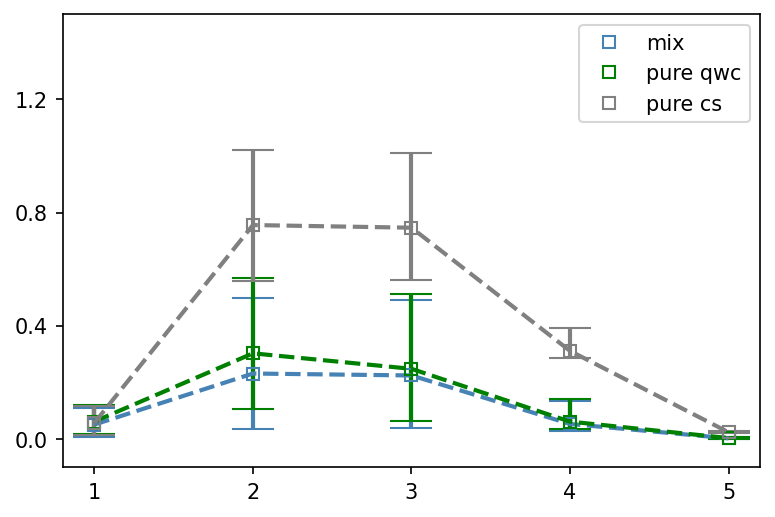

In [34]:
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import StrMethodFormatter
import scipy.stats as st
confidence_intervals = []
for i in range(len(ks)):
    e_data = errors["mix_energy"][i]
    c = st.t.interval(alpha=0.95, df=len(e_data)-1, loc=np.mean(e_data), scale=st.sem(e_data)) 
    confidence_intervals += [c]
confidence_intervals = np.array(confidence_intervals).T
print(confidence_intervals)

plt.errorbar(ks, [np.mean(errors["mix_energy"][i]) for i in range(len(ks))], 
             yerr=confidence_intervals, lw =2, ls="dashed", capsize=10, color=colors[0])
plt.errorbar(ks, [np.mean(errors["mix_energy"][i]) for i in range(len(ks))], marker="s", fillstyle="none",ls="none",label="mix", color=colors[0])

confidence_intervals = []
for i in range(len(ks)):
    e_data = errors["mix_energy"][i]
    c = st.t.interval(alpha=0.95, df=len(e_data)-1, loc=np.mean(e_data), scale=st.sem(e_data)) 
    confidence_intervals += [c]
confidence_intervals = np.array(confidence_intervals).T
plt.errorbar(ks, [np.mean(errors["qwc_energy"][i]) for i in range(len(ks))], 
             yerr=confidence_intervals, lw =2, ls="dashed", capsize=10, color=colors[1])
plt.errorbar(ks, [np.mean(errors["qwc_energy"][i]) for i in range(len(ks))], marker="s", fillstyle="none",ls="none",label="pure qwc", color=colors[1])

confidence_intervals = []
for i in range(len(ks)):
    e_data = errors["mix_energy"][i]
    c = st.t.interval(alpha=0.95, df=len(e_data)-1, loc=np.mean(e_data), scale=st.sem(e_data)) 
    confidence_intervals += [c]
confidence_intervals = np.array(confidence_intervals).T
    
plt.errorbar(ks, [np.mean(errors["cs_energy"][i]) for i in range(len(ks))], 
             yerr=confidence_intervals, lw =2, ls="dashed", capsize=10, color=colors[2])
plt.errorbar(ks, [np.mean(errors["cs_energy"][i]) for i in range(len(ks))], marker="s", fillstyle="none",ls="none",label="pure cs", color=colors[2])
plt.legend()
plt.xticks([1,2,3,4,5])
plt.yticks([0,0.4,0.8,1.2])
plt.ylim((-0.1, 1.5))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) # 2 decimal places
min_e = np.min(np.linalg.eigh(ham_mat)[0])
plt.savefig("figures/mae_confidence_intervals_"+system+".jpg")

#### ** some extra code to analyze the moment estimations for each method

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


[0, 0.0, (1+0j), (1+0j)]


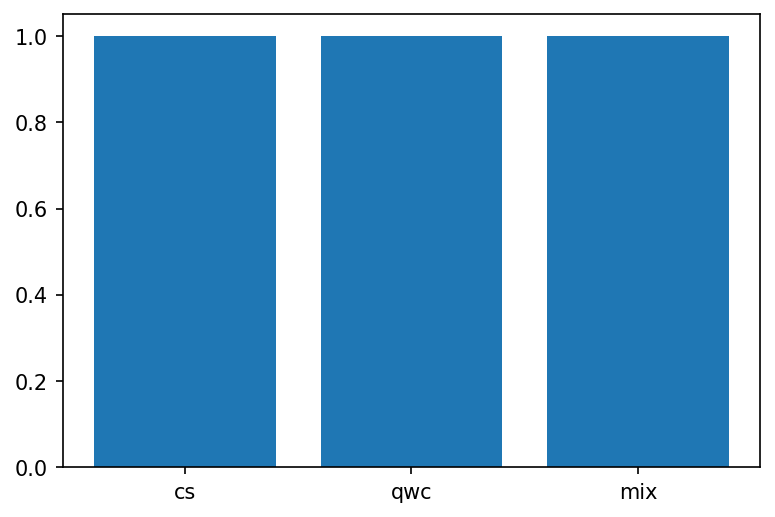

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


[1, 0.06855262910798166, (1.840625+0j), (1.8337239583333333+0j)]


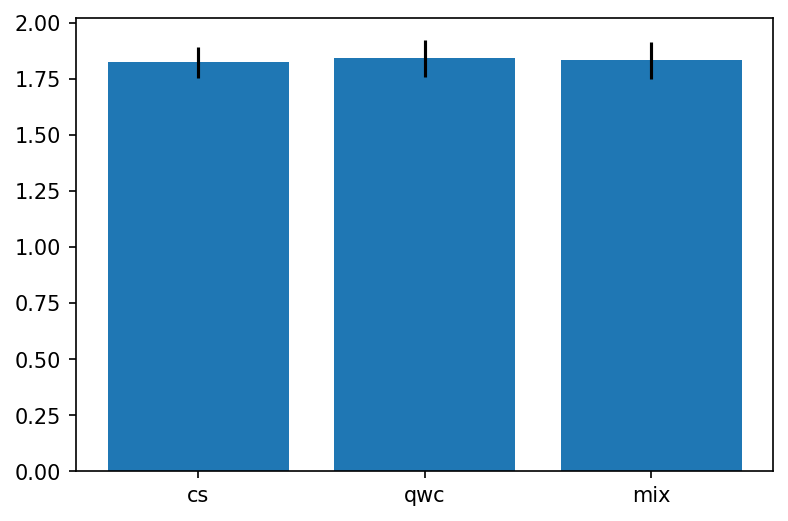

[2, 0.4599141269396622, (6.920963541666667+0j), (6.89541015625+0j)]


/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


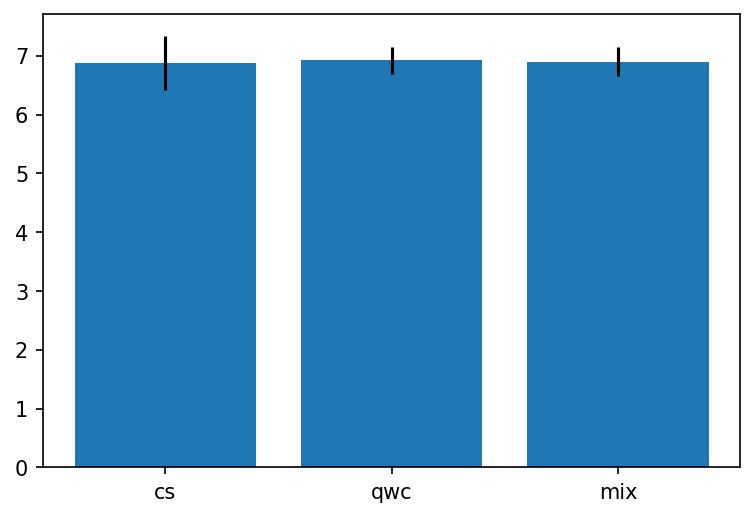

[3, 2.8343312767252473, (10.149837239583333+0j), (10.265690104166666+0j)]


/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


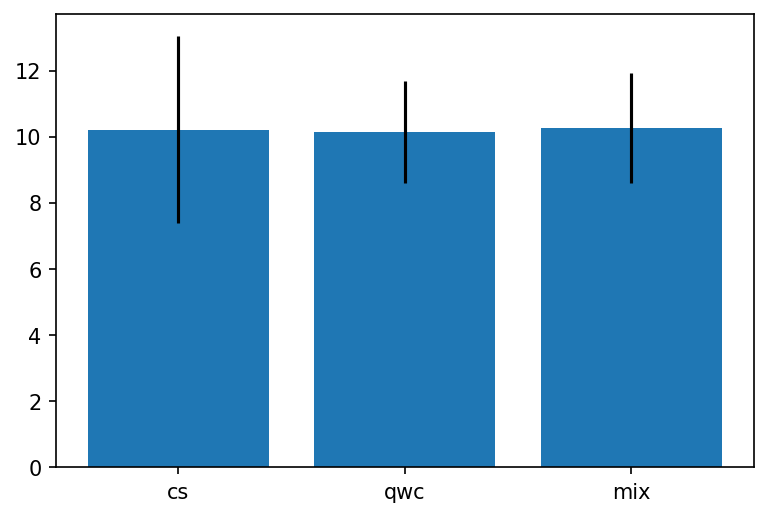

[4, 21.06819512409461, (83.74361979166666+0j), (82.24225260416667+0j)]


/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


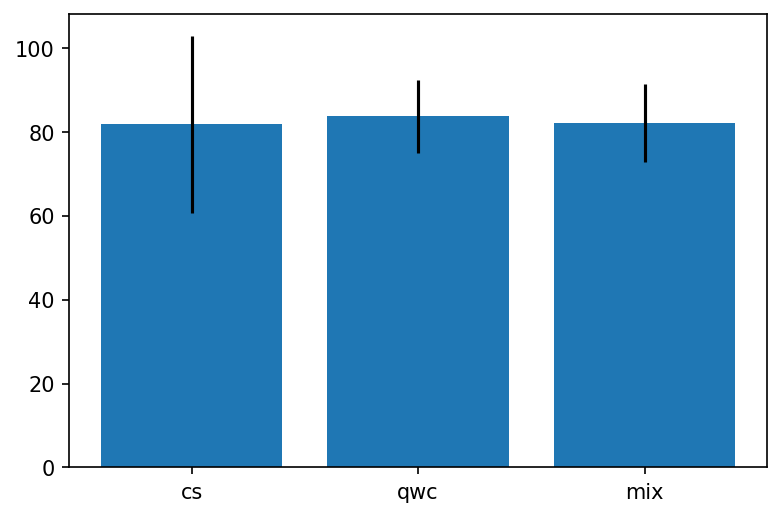

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[5, 137.4273177676959, (-65.5888671875+0j), (-55.957812499999996+0j)]


/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


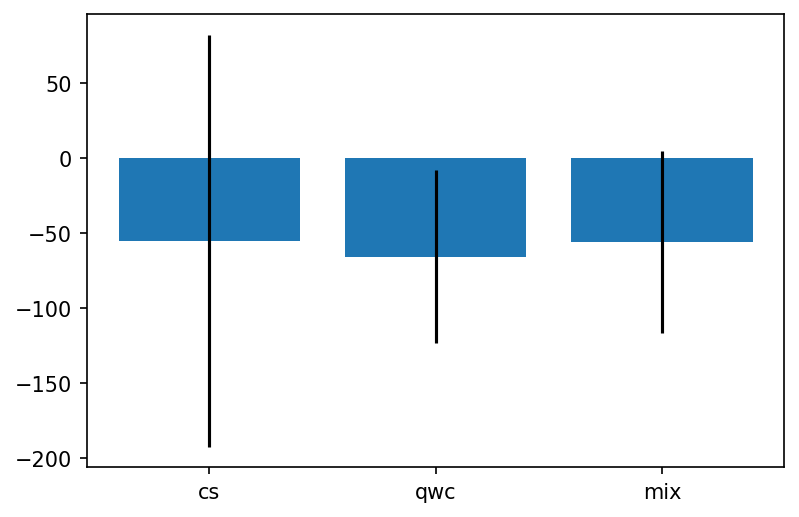

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


[6, 928.1947388472965, (1695.5916666666667+0j), (1624.62724609375+0j)]


/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


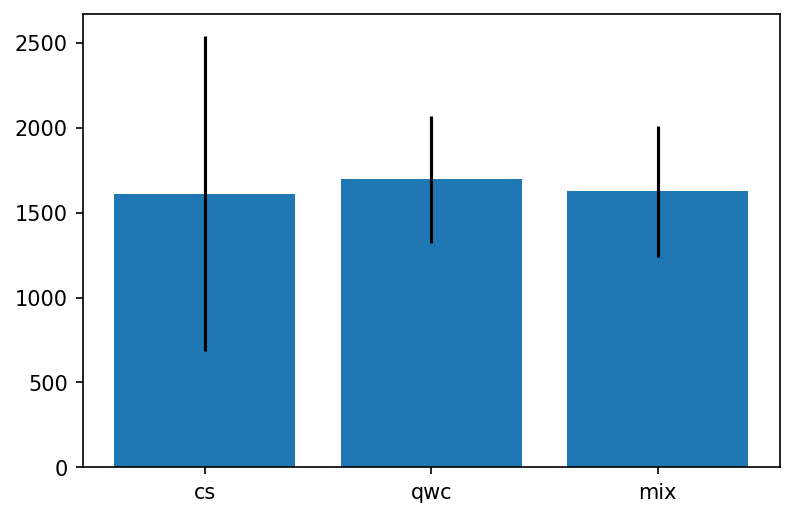

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[7, 6053.766854000426, (-6640.656477864583+0j), (-6175.933919270833+0j)]


/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


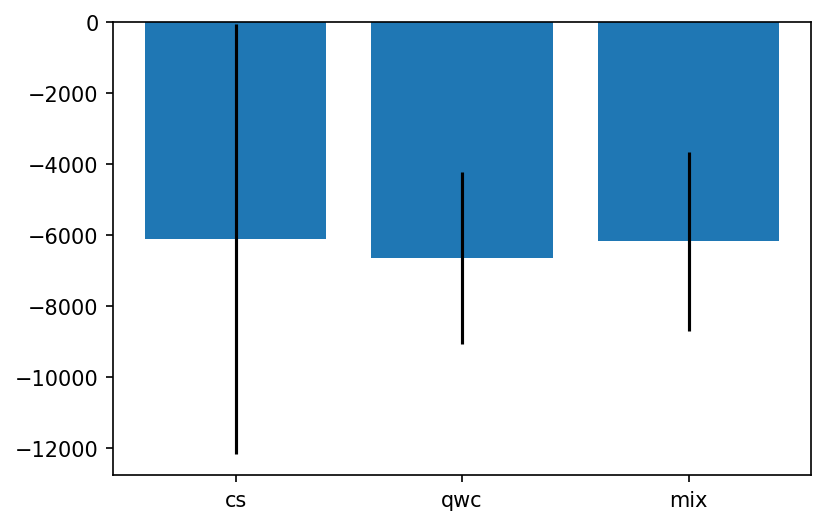

[8, 39661.28250356337, (53789.438802083336+0j), (50679.893359375+0j)]


/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


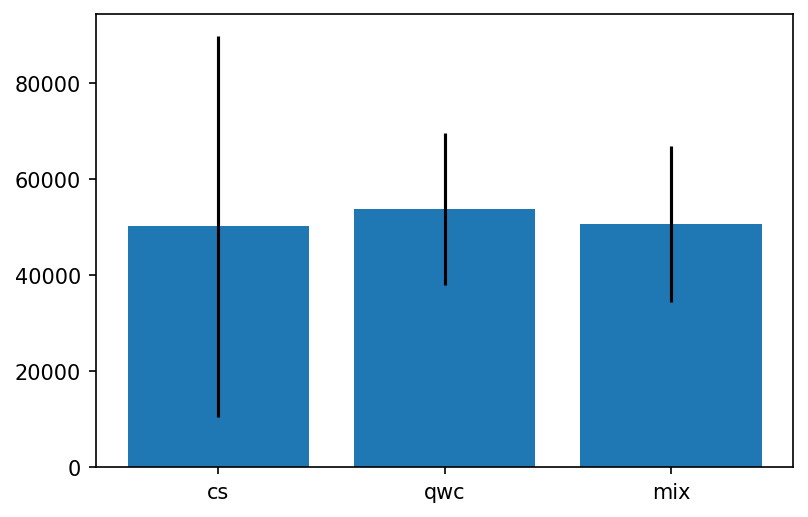

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


[9, 257466.67142736763, (-307384.871484375+0j), (-287129.22018229164+0j)]


/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


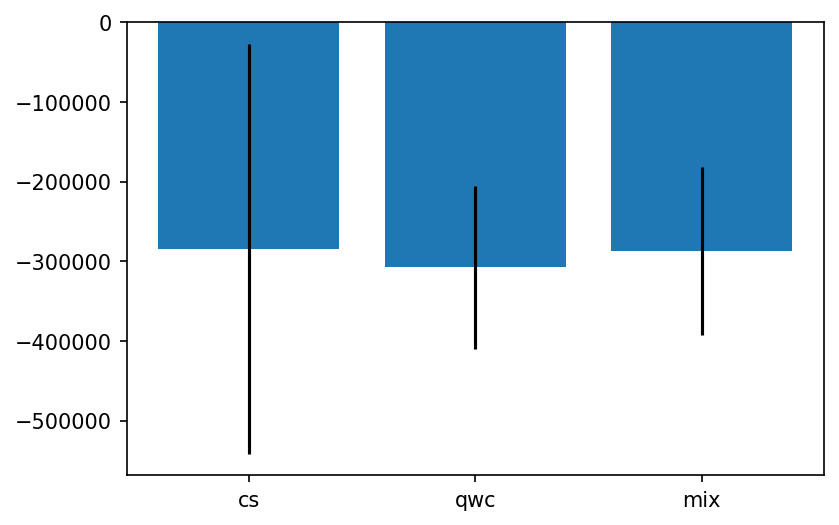

[ 1.00000000e+00+0.j  1.78117565e+00+0.j  7.03634551e+00+0.j
  8.93164817e+00+0.j  8.52444654e+01+0.j -7.98499364e+01+0.j
  1.70734652e+03+0.j -6.71985481e+03+0.j  5.33455506e+04+0.j
 -3.03821398e+05+0.j]
[ 1.00000000e+00+0.j  1.81704622e+00+0.j  7.60188257e+00+0.j
  6.85511595e+00+0.j  1.07673525e+02+0.j -2.06242429e+02+0.j
  2.62274563e+03+0.j -1.24812432e+04+0.j  9.16276456e+04+0.j
 -5.50276256e+05+0.j]
[ 1.00000000e+00+0.j  1.80427892e+00+0.j  7.27971412e+00+0.j
  7.96117648e+00+0.j  9.90078953e+01+0.j -1.63010114e+02+0.j
  2.33715960e+03+0.j -1.07820814e+04+0.j  8.06921383e+04+0.j
 -4.81327212e+05+0.j]
[ 1.00000000e+00+0.j  1.91125198e+00+0.j  7.52535720e+00+0.j
  6.84658947e+00+0.j  1.14775304e+02+0.j -2.66998577e+02+0.j
  3.10625008e+03+0.j -1.58607022e+04+0.j  1.14714259e+05+0.j
 -7.03481390e+05+0.j]
[ 1.00000000e+00+0.j  1.72669474e+00+0.j  7.44787946e+00+0.j
  6.81988963e+00+0.j  9.59970981e+01+0.j -1.40945513e+02+0.j
  2.05609788e+03+0.j -8.84479121e+03+0.j  6.64284619e+04+0

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


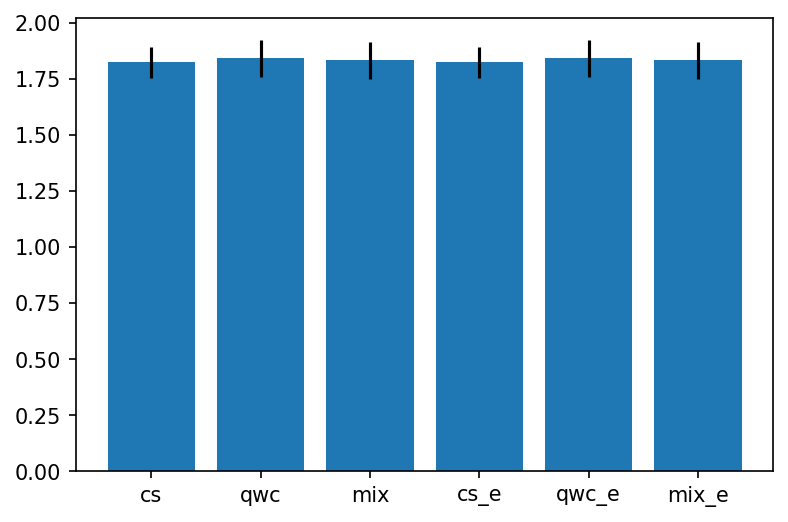

[ 1.00000000e+00+0.j  1.78117565e+00+0.j  7.03634551e+00+0.j
  8.93164817e+00+0.j  8.52444654e+01+0.j -7.98499364e+01+0.j
  1.70734652e+03+0.j -6.71985481e+03+0.j  5.33455506e+04+0.j
 -3.03821398e+05+0.j]
[ 1.00000000e+00+0.j  1.81704622e+00+0.j  7.60188257e+00+0.j
  6.85511595e+00+0.j  1.07673525e+02+0.j -2.06242429e+02+0.j
  2.62274563e+03+0.j -1.24812432e+04+0.j  9.16276456e+04+0.j
 -5.50276256e+05+0.j]
[ 1.00000000e+00+0.j  1.80427892e+00+0.j  7.27971412e+00+0.j
  7.96117648e+00+0.j  9.90078953e+01+0.j -1.63010114e+02+0.j
  2.33715960e+03+0.j -1.07820814e+04+0.j  8.06921383e+04+0.j
 -4.81327212e+05+0.j]
[ 1.00000000e+00+0.j  1.91125198e+00+0.j  7.52535720e+00+0.j
  6.84658947e+00+0.j  1.14775304e+02+0.j -2.66998577e+02+0.j
  3.10625008e+03+0.j -1.58607022e+04+0.j  1.14714259e+05+0.j
 -7.03481390e+05+0.j]
[ 1.00000000e+00+0.j  1.72669474e+00+0.j  7.44787946e+00+0.j
  6.81988963e+00+0.j  9.59970981e+01+0.j -1.40945513e+02+0.j
  2.05609788e+03+0.j -8.84479121e+03+0.j  6.64284619e+04+0

 -1.40643684e+05+0.j]
[ 1.00000000e+00+0.j  1.88740923e+00+0.j  6.69427821e+00+0.j
  1.18511247e+01+0.j  7.31243702e+01+0.j  1.20987771e+00+0.j
  1.26395988e+03+0.j -3.88512368e+03+0.j  3.59861305e+04+0.j
 -1.92749296e+05+0.j]
[ 1.00000000e+00+0.j  1.78313081e+00+0.j  7.13104425e+00+0.j
  9.21040556e+00+0.j  8.79927907e+01+0.j -8.43017131e+01+0.j
  1.79125329e+03+0.j -7.13058105e+03+0.j  5.65704567e+04+0.j
 -3.23544887e+05+0.j]
[ 1.00000000e+00+0.j  1.68840405e+00+0.j  7.12081473e+00+0.j
  7.53258958e+00+0.j  8.62784206e+01+0.j -8.86365281e+01+0.j
  1.67140148e+03+0.j -6.43414098e+03+0.j  5.03856774e+04+0.j
 -2.83155140e+05+0.j]
[ 1.00000000e+00+0.j  1.73296355e+00+0.j  6.39968354e+00+0.j
  1.33960353e+01+0.j  5.28871851e+01+0.j  1.44804142e+02+0.j
  2.24228823e+02+0.j  3.10517261e+03+0.j -1.06477240e+04+0.j
  1.13091866e+05+0.j]
[ 1.00000000e+00+0.j  1.85652458e+00+0.j  7.24099205e+00+0.j
  8.93471814e+00+0.j  9.75503951e+01+0.j -1.48332425e+02+0.j
  2.29727422e+03+0.j -1.05048404e+04

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


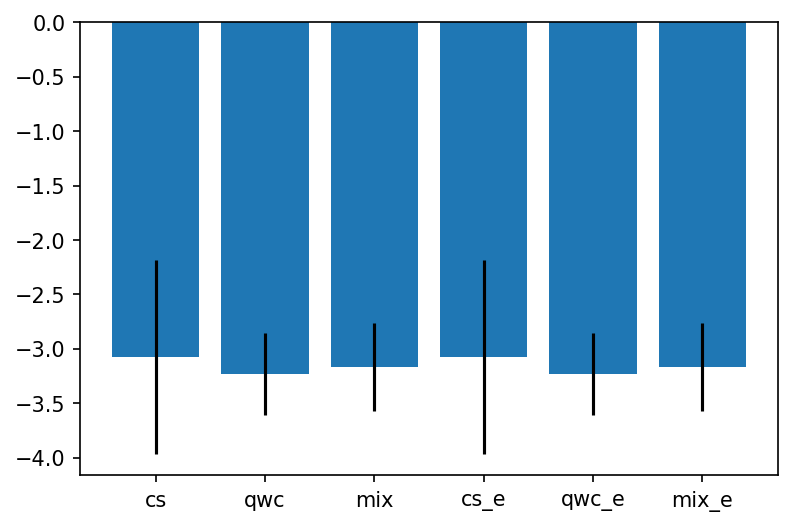

[ 1.00000000e+00+0.j  1.78117565e+00+0.j  7.03634551e+00+0.j
  8.93164817e+00+0.j  8.52444654e+01+0.j -7.98499364e+01+0.j
  1.70734652e+03+0.j -6.71985481e+03+0.j  5.33455506e+04+0.j
 -3.03821398e+05+0.j]
[ 1.00000000e+00+0.j  1.81704622e+00+0.j  7.60188257e+00+0.j
  6.85511595e+00+0.j  1.07673525e+02+0.j -2.06242429e+02+0.j
  2.62274563e+03+0.j -1.24812432e+04+0.j  9.16276456e+04+0.j
 -5.50276256e+05+0.j]
[ 1.00000000e+00+0.j  1.80427892e+00+0.j  7.27971412e+00+0.j
  7.96117648e+00+0.j  9.90078953e+01+0.j -1.63010114e+02+0.j
  2.33715960e+03+0.j -1.07820814e+04+0.j  8.06921383e+04+0.j
 -4.81327212e+05+0.j]
[ 1.00000000e+00+0.j  1.91125198e+00+0.j  7.52535720e+00+0.j
  6.84658947e+00+0.j  1.14775304e+02+0.j -2.66998577e+02+0.j
  3.10625008e+03+0.j -1.58607022e+04+0.j  1.14714259e+05+0.j
 -7.03481390e+05+0.j]
[ 1.00000000e+00+0.j  1.72669474e+00+0.j  7.44787946e+00+0.j
  6.81988963e+00+0.j  9.59970981e+01+0.j -1.40945513e+02+0.j
  2.05609788e+03+0.j -8.84479121e+03+0.j  6.64284619e+04+0

 -1.23948362e+05+0.j]
[ 1.00000000e+00+0.j  1.82542704e+00+0.j  7.34581949e+00+0.j
  6.72781268e+00+0.j  1.13148305e+02+0.j -2.65494758e+02+0.j
  3.08922398e+03+0.j -1.58305425e+04+0.j  1.14539549e+05+0.j
 -7.03222848e+05+0.j]
[ 1.00000000e+00+0.j  1.81443002e+00+0.j  7.28778121e+00+0.j
  7.30857079e+00+0.j  1.02066714e+02+0.j -1.94055371e+02+0.j
  2.52390217e+03+0.j -1.21255800e+04+0.j  8.92958595e+04+0.j
 -5.38503671e+05+0.j]
[ 1.00000000e+00+0.j  1.99469041e+00+0.j  6.29626785e+00+0.j
  1.39893086e+01+0.j  6.21429681e+01+0.j  6.30974699e+01+0.j
  9.01688940e+02+0.j -1.68397815e+03+0.j  2.22998746e+04+0.j
 -1.06359592e+05+0.j]
[ 1.00000000e+00+0.j  1.81141046e+00+0.j  6.23296355e+00+0.j
  1.23397779e+01+0.j  6.42950902e+01+0.j  3.21537018e+01+0.j
  1.02429462e+03+0.j -2.60408670e+03+0.j  2.74784744e+04+0.j
 -1.40643684e+05+0.j]
[ 1.00000000e+00+0.j  1.88740923e+00+0.j  6.69427821e+00+0.j
  1.18511247e+01+0.j  7.31243702e+01+0.j  1.20987771e+00+0.j
  1.26395988e+03+0.j -3.88512368e+03

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


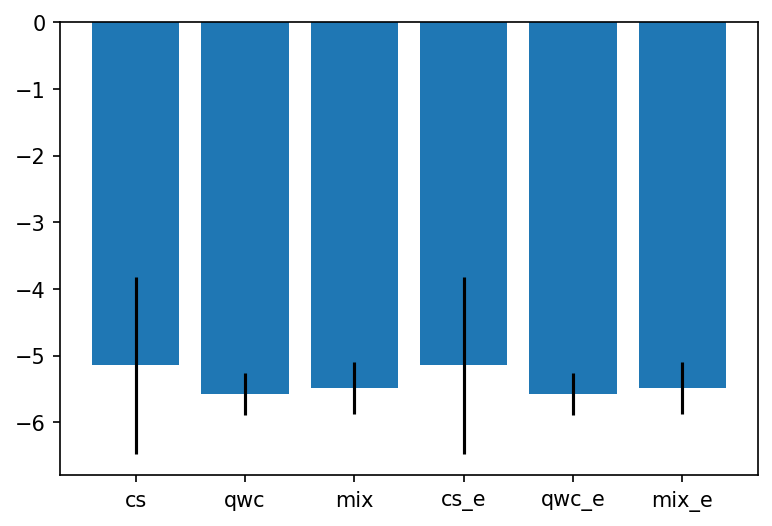

[ 1.00000000e+00+0.j  1.78117565e+00+0.j  7.03634551e+00+0.j
  8.93164817e+00+0.j  8.52444654e+01+0.j -7.98499364e+01+0.j
  1.70734652e+03+0.j -6.71985481e+03+0.j  5.33455506e+04+0.j
 -3.03821398e+05+0.j]
[ 1.00000000e+00+0.j  1.81704622e+00+0.j  7.60188257e+00+0.j
  6.85511595e+00+0.j  1.07673525e+02+0.j -2.06242429e+02+0.j
  2.62274563e+03+0.j -1.24812432e+04+0.j  9.16276456e+04+0.j
 -5.50276256e+05+0.j]
[ 1.00000000e+00+0.j  1.80427892e+00+0.j  7.27971412e+00+0.j
  7.96117648e+00+0.j  9.90078953e+01+0.j -1.63010114e+02+0.j
  2.33715960e+03+0.j -1.07820814e+04+0.j  8.06921383e+04+0.j
 -4.81327212e+05+0.j]
[ 1.00000000e+00+0.j  1.91125198e+00+0.j  7.52535720e+00+0.j
  6.84658947e+00+0.j  1.14775304e+02+0.j -2.66998577e+02+0.j
  3.10625008e+03+0.j -1.58607022e+04+0.j  1.14714259e+05+0.j
 -7.03481390e+05+0.j]
[ 1.00000000e+00+0.j  1.72669474e+00+0.j  7.44787946e+00+0.j
  6.81988963e+00+0.j  9.59970981e+01+0.j -1.40945513e+02+0.j
  2.05609788e+03+0.j -8.84479121e+03+0.j  6.64284619e+04+0

 -1.01518476e+06+0.j]
[ 1.00000000e+00+0.j  1.76862124e+00+0.j  6.66677166e+00+0.j
  1.10561572e+01+0.j  7.02502655e+01+0.j  2.02770649e+01+0.j
  1.05544905e+03+0.j -2.44478505e+03+0.j  2.56469002e+04+0.j
 -1.23948362e+05+0.j]
[ 1.00000000e+00+0.j  1.82542704e+00+0.j  7.34581949e+00+0.j
  6.72781268e+00+0.j  1.13148305e+02+0.j -2.65494758e+02+0.j
  3.08922398e+03+0.j -1.58305425e+04+0.j  1.14539549e+05+0.j
 -7.03222848e+05+0.j]
[ 1.00000000e+00+0.j  1.81443002e+00+0.j  7.28778121e+00+0.j
  7.30857079e+00+0.j  1.02066714e+02+0.j -1.94055371e+02+0.j
  2.52390217e+03+0.j -1.21255800e+04+0.j  8.92958595e+04+0.j
 -5.38503671e+05+0.j]
[ 1.00000000e+00+0.j  1.99469041e+00+0.j  6.29626785e+00+0.j
  1.39893086e+01+0.j  6.21429681e+01+0.j  6.30974699e+01+0.j
  9.01688940e+02+0.j -1.68397815e+03+0.j  2.22998746e+04+0.j
 -1.06359592e+05+0.j]
[ 1.00000000e+00+0.j  1.81141046e+00+0.j  6.23296355e+00+0.j
  1.23397779e+01+0.j  6.42950902e+01+0.j  3.21537018e+01+0.j
  1.02429462e+03+0.j -2.60408670e+03

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


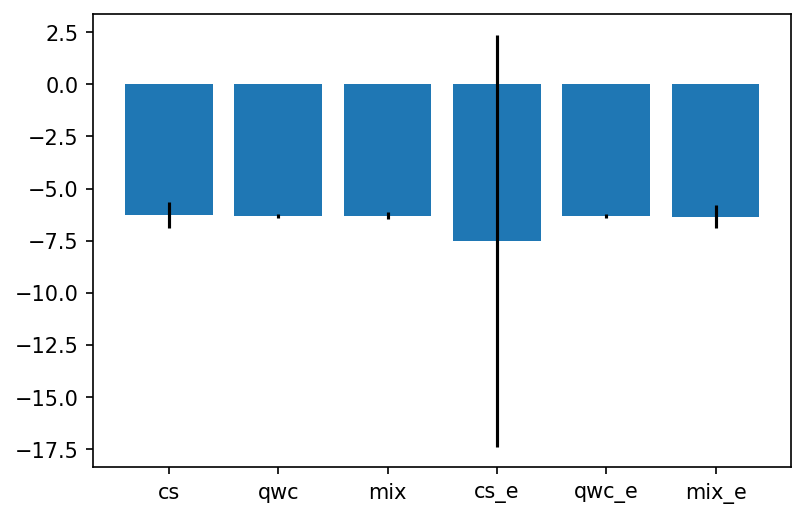

[ 1.00000000e+00+0.j  1.78117565e+00+0.j  7.03634551e+00+0.j
  8.93164817e+00+0.j  8.52444654e+01+0.j -7.98499364e+01+0.j
  1.70734652e+03+0.j -6.71985481e+03+0.j  5.33455506e+04+0.j
 -3.03821398e+05+0.j]
[ 1.00000000e+00+0.j  1.81704622e+00+0.j  7.60188257e+00+0.j
  6.85511595e+00+0.j  1.07673525e+02+0.j -2.06242429e+02+0.j
  2.62274563e+03+0.j -1.24812432e+04+0.j  9.16276456e+04+0.j
 -5.50276256e+05+0.j]
[ 1.00000000e+00+0.j  1.80427892e+00+0.j  7.27971412e+00+0.j
  7.96117648e+00+0.j  9.90078953e+01+0.j -1.63010114e+02+0.j
  2.33715960e+03+0.j -1.07820814e+04+0.j  8.06921383e+04+0.j
 -4.81327212e+05+0.j]
[ 1.00000000e+00+0.j  1.91125198e+00+0.j  7.52535720e+00+0.j
  6.84658947e+00+0.j  1.14775304e+02+0.j -2.66998577e+02+0.j
  3.10625008e+03+0.j -1.58607022e+04+0.j  1.14714259e+05+0.j
 -7.03481390e+05+0.j]
[ 1.00000000e+00+0.j  1.72669474e+00+0.j  7.44787946e+00+0.j
  6.81988963e+00+0.j  9.59970981e+01+0.j -1.40945513e+02+0.j
  2.05609788e+03+0.j -8.84479121e+03+0.j  6.64284619e+04+0

 -1.06359592e+05+0.j]
[ 1.00000000e+00+0.j  1.81141046e+00+0.j  6.23296355e+00+0.j
  1.23397779e+01+0.j  6.42950902e+01+0.j  3.21537018e+01+0.j
  1.02429462e+03+0.j -2.60408670e+03+0.j  2.74784744e+04+0.j
 -1.40643684e+05+0.j]
[ 1.00000000e+00+0.j  1.88740923e+00+0.j  6.69427821e+00+0.j
  1.18511247e+01+0.j  7.31243702e+01+0.j  1.20987771e+00+0.j
  1.26395988e+03+0.j -3.88512368e+03+0.j  3.59861305e+04+0.j
 -1.92749296e+05+0.j]
[ 1.00000000e+00+0.j  1.78313081e+00+0.j  7.13104425e+00+0.j
  9.21040556e+00+0.j  8.79927907e+01+0.j -8.43017131e+01+0.j
  1.79125329e+03+0.j -7.13058105e+03+0.j  5.65704567e+04+0.j
 -3.23544887e+05+0.j]
[ 1.00000000e+00+0.j  1.68840405e+00+0.j  7.12081473e+00+0.j
  7.53258958e+00+0.j  8.62784206e+01+0.j -8.86365281e+01+0.j
  1.67140148e+03+0.j -6.43414098e+03+0.j  5.03856774e+04+0.j
 -2.83155140e+05+0.j]
[ 1.00000000e+00+0.j  1.73296355e+00+0.j  6.39968354e+00+0.j
  1.33960353e+01+0.j  5.28871851e+01+0.j  1.44804142e+02+0.j
  2.24228823e+02+0.j  3.10517261e+03

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


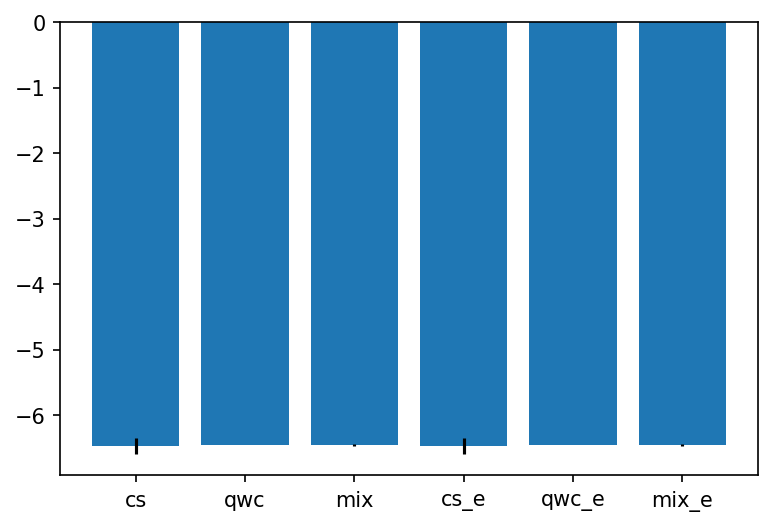

[ 1.00000000e+00+0.j  1.78117565e+00+0.j  7.03634551e+00+0.j
  8.93164817e+00+0.j  8.52444654e+01+0.j -7.98499364e+01+0.j
  1.70734652e+03+0.j -6.71985481e+03+0.j  5.33455506e+04+0.j
 -3.03821398e+05+0.j]


IndexError: index 10 is out of bounds for axis 0 with size 10

In [156]:
# moment data analysis
for i in range(2*K):
    cs_moments = [complex(s) for s in data["cs_moments"][i]]
    qwc_moments = [complex(s) for s in data["qwc_moments"][i]]
    mix_moments = [complex(s) for s in data["mix_moments"][i]]
    plt.bar(["cs","qwc","mix"],[np.mean(cs_moments), np.mean(qwc_moments), np.mean(mix_moments)], 
           yerr = [np.std(cs_moments), np.std(qwc_moments), np.std(mix_moments)])
    print([i, np.std(cs_moments), np.mean(qwc_moments), np.mean(mix_moments)])
    plt.show()
cs_moments = np.array([[complex(s) for s in data["cs_moments"][i]] for i in range(2*K)])
qwc_moments = np.array([[complex(s) for s in data["qwc_moments"][i]] for i in range(2*K)])
mix_moments = np.array([[complex(s) for s in data["mix_moments"][i]] for i in range(2*K)])
for i in range(6):
    cs_e = []
    qwc_e = []
    mix_e = []
    for n_ in range(n_points):
        print(cs_moments[:,n_])
        cs_e += [comp_energy(cs_moments[:,n_], i+1)]
        qwc_e += [comp_energy(qwc_moments[:,n_], i+1)]
        mix_e += [comp_energy(mix_moments[:,n_], i+1)]
    cs_energy = [complex(s) for s in data_no_outliers["cs_energy"][i]]
    qwc_energy = [complex(s) for s in data_no_outliers["qwc_energy"][i]]
    mix_energy = [complex(s) for s in data_no_outliers["mix_energy"][i]]
    plt.bar(["cs","qwc","mix", "cs_e", "qwc_e", "mix_e"],[np.mean(cs_energy), np.mean(qwc_energy), np.mean(mix_energy), np.mean(cs_e), np.mean(qwc_e), np.mean(mix_e)], 
           yerr = [np.std(cs_energy), np.std(qwc_energy), np.std(mix_energy), np.std(cs_e), np.std(qwc_e), np.std(mix_e)])
    plt.show()